不動産価格予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"

%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


In [ ]:
# zipファイルの解凍

# 古いdata.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

In [ ]:
# train.zipの解凍
# 古いtrain.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data/train

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

!rm -r /content/drive/MyDrive/property_values_prediction/data/__MACOSX

rm: cannot remove '/content/drive/MyDrive/property_values_prediction/data/train': No such file or directory


In [ ]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [ ]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

In [ ]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


In [ ]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [ ]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [ ]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

In [ ]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [ ]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [ ]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [ ]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [ ]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [ ]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [ ]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [ ]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,27232131,大阪府,大阪市旭区,新森,森小路,6,１ＬＤＫ,50,昭和49年,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,2005年第３四半期,改装済,NaN,7.041393,0,0.0
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7,３ＬＤＫ,60,平成4年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2005年第３四半期,改装済,NaN,7.361728,0,0.0


In [ ]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [ ]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [ ]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [ ]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0


In [ ]:
feat_df = pd.concat([num_df,le_df,num_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 38)


In [ ]:
feat_df.dtypes

ID                                   int64
最寄駅：距離（分）                          float64
面積（㎡）                                int64
建築年                                float64
建ぺい率（％）                            float64
容積率（％）                             float64
取引価格（総額）_log                       float64
取引時点_enc                             int64
都道府県名_te                           float64
取引時点_何年前                             int64
都道府県名                                int64
市区町村名                                int64
地区名                                  int64
最寄駅：名称                               int64
間取り                                  int64
建物の構造                                int64
用途                                   int64
今後の利用目的                              int64
都市計画                                 int64
改装                                   int64
取引の事情等                               int64
面積（㎡）容積率（％）_combi                  float64
agg_count_最寄駅：距離（分）_grpby_市区町村名      int64
agg_count_面

In [ ]:
# カーネルが落ちるため、float32へ変換する
trans_cols_float32 = ["最寄駅：距離（分）",
                      "建築年", "建ぺい率（％）",
                      "容積率（％）", "都道府県名_te",
                      "面積（㎡）容積率（％）_combi",
                      "agg_mean_最寄駅：距離（分）_grpby_市区町村名",
                      "agg_mean_面積（㎡）_grpby_市区町村名",
                      "agg_mean_建ぺい率（％）_grpby_市区町村名",
                      "agg_mean_容積率（％）_grpby_市区町村名",
                      "agg_min_最寄駅：距離（分）_grpby_市区町村名",
                      "agg_min_建ぺい率（％）_grpby_市区町村名",
                      "agg_min_容積率（％）_grpby_市区町村名",
                      "agg_max_最寄駅：距離（分）_grpby_市区町村名",
                      "agg_max_建ぺい率（％）_grpby_市区町村名",
                      "agg_max_容積率（％）_grpby_市区町村名",
                      "取引価格（総額）_log",
                      ]

feat_df[trans_cols_float32] = feat_df[trans_cols_float32].astype("float32")
feat_df.dtypes

ID                                   int64
最寄駅：距離（分）                          float32
面積（㎡）                                int64
建築年                                float32
建ぺい率（％）                            float32
容積率（％）                             float32
取引価格（総額）_log                       float32
取引時点_enc                             int64
都道府県名_te                           float32
取引時点_何年前                             int64
都道府県名                                int64
市区町村名                                int64
地区名                                  int64
最寄駅：名称                               int64
間取り                                  int64
建物の構造                                int64
用途                                   int64
今後の利用目的                              int64
都市計画                                 int64
改装                                   int64
取引の事情等                               int64
面積（㎡）容積率（％）_combi                  float32
agg_count_最寄駅：距離（分）_grpby_市区町村名      int64
agg_count_面

モデル構築

In [ ]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 38) (24899, 38) (23151, 38)


In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
def objective(trial):

    params = {
        "objective": "mean_squared_error",
        "metric": "rmse",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # LightGBMを利用するのに必要なフォーマットに変換
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

    # 学習の経過を保存する箱
    evaluation_results = {}

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_names=["train", "valid"],
        valid_sets=[lgb_train, lgb_eval],
        evals_result=evaluation_results,
        verbose_eval=100,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [ ]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50)

[I 2021-11-29 04:04:28,469] A new study created in memory with name: no-name-f5438284-b894-4cd2-a8db-75e181dadeb0


[100]	train's rmse: 0.132537	valid's rmse: 0.138319
[200]	train's rmse: 0.125519	valid's rmse: 0.133433
[300]	train's rmse: 0.121359	valid's rmse: 0.131426
[400]	train's rmse: 0.118145	valid's rmse: 0.130435
[500]	train's rmse: 0.115505	valid's rmse: 0.129893


[I 2021-11-29 04:05:38,626] Trial 0 finished with value: 0.08023774170022667 and parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 163, 'feature_fraction': 0.8492823295231671, 'bagging_fraction': 0.6991042073815543, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 0 with value: 0.08023774170022667.


[100]	train's rmse: 0.148093	valid's rmse: 0.152671
[200]	train's rmse: 0.141183	valid's rmse: 0.144955
[300]	train's rmse: 0.137962	valid's rmse: 0.14178
[400]	train's rmse: 0.135773	valid's rmse: 0.139583
[500]	train's rmse: 0.13413	valid's rmse: 0.138038


[I 2021-11-29 04:06:23,584] Trial 1 finished with value: 0.08743748474472043 and parameters: {'lambda_l1': 0.0699481785242808, 'lambda_l2': 3.32657660618516e-07, 'num_leaves': 24, 'feature_fraction': 0.8112158910206784, 'bagging_fraction': 0.972036007716962, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 0 with value: 0.08023774170022667.


[100]	train's rmse: 0.132337	valid's rmse: 0.137987
[200]	train's rmse: 0.125485	valid's rmse: 0.133167
[300]	train's rmse: 0.121663	valid's rmse: 0.131189
[400]	train's rmse: 0.118699	valid's rmse: 0.129998
[500]	train's rmse: 0.116285	valid's rmse: 0.129282


[I 2021-11-29 04:07:33,419] Trial 2 finished with value: 0.07902812393295033 and parameters: {'lambda_l1': 0.20586790968905005, 'lambda_l2': 0.003256376421394008, 'num_leaves': 186, 'feature_fraction': 0.5751256409023799, 'bagging_fraction': 0.9506644735077661, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.13267	valid's rmse: 0.138022
[200]	train's rmse: 0.125997	valid's rmse: 0.133514
[300]	train's rmse: 0.122173	valid's rmse: 0.131832
[400]	train's rmse: 0.119309	valid's rmse: 0.130702
[500]	train's rmse: 0.116887	valid's rmse: 0.130107


[I 2021-11-29 04:08:38,179] Trial 3 finished with value: 0.07975270335012986 and parameters: {'lambda_l1': 1.9034015928564192e-07, 'lambda_l2': 2.2912202578440842e-05, 'num_leaves': 173, 'feature_fraction': 0.6650999046537976, 'bagging_fraction': 0.6604083959999762, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.130272	valid's rmse: 0.136631
[200]	train's rmse: 0.122701	valid's rmse: 0.132181
[300]	train's rmse: 0.118206	valid's rmse: 0.130723
[400]	train's rmse: 0.114664	valid's rmse: 0.129945
[500]	train's rmse: 0.111684	valid's rmse: 0.129418


[I 2021-11-29 04:09:51,642] Trial 4 finished with value: 0.07977283500919684 and parameters: {'lambda_l1': 0.007137968669448066, 'lambda_l2': 0.0025665550309028774, 'num_leaves': 207, 'feature_fraction': 0.7129882914361805, 'bagging_fraction': 0.945189328485201, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.131927	valid's rmse: 0.137588
[200]	train's rmse: 0.125076	valid's rmse: 0.132775
[300]	train's rmse: 0.121522	valid's rmse: 0.131093
[400]	train's rmse: 0.118613	valid's rmse: 0.130238
[500]	train's rmse: 0.116275	valid's rmse: 0.129586


[I 2021-11-29 04:10:57,162] Trial 5 finished with value: 0.07921598180269557 and parameters: {'lambda_l1': 5.085111847677709e-06, 'lambda_l2': 1.0613515458050516e-07, 'num_leaves': 213, 'feature_fraction': 0.42813779163354987, 'bagging_fraction': 0.7757722889868355, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.137375	valid's rmse: 0.142418
[200]	train's rmse: 0.131096	valid's rmse: 0.136636
[300]	train's rmse: 0.127739	valid's rmse: 0.134202
[400]	train's rmse: 0.125196	valid's rmse: 0.133103
[500]	train's rmse: 0.123094	valid's rmse: 0.132347


[I 2021-11-29 04:11:51,042] Trial 6 finished with value: 0.0824412216866199 and parameters: {'lambda_l1': 6.173448891970491e-07, 'lambda_l2': 0.5148168134404182, 'num_leaves': 91, 'feature_fraction': 0.8527886149179144, 'bagging_fraction': 0.5775770241278072, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.147873	valid's rmse: 0.152103
[200]	train's rmse: 0.140876	valid's rmse: 0.14415
[300]	train's rmse: 0.137816	valid's rmse: 0.141086
[400]	train's rmse: 0.135882	valid's rmse: 0.139314
[500]	train's rmse: 0.134192	valid's rmse: 0.137746


[I 2021-11-29 04:12:30,359] Trial 7 finished with value: 0.0871550311896442 and parameters: {'lambda_l1': 3.055927730910031e-07, 'lambda_l2': 3.4100692264414245e-05, 'num_leaves': 25, 'feature_fraction': 0.892663394702157, 'bagging_fraction': 0.4906912117855383, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.134272	valid's rmse: 0.140182
[200]	train's rmse: 0.128509	valid's rmse: 0.13507
[300]	train's rmse: 0.125577	valid's rmse: 0.133032
[400]	train's rmse: 0.123598	valid's rmse: 0.131878
[500]	train's rmse: 0.1221	valid's rmse: 0.131129


[I 2021-11-29 04:13:57,871] Trial 8 finished with value: 0.08000836457630628 and parameters: {'lambda_l1': 7.738009776978926, 'lambda_l2': 0.00012786183233975197, 'num_leaves': 212, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.138057	valid's rmse: 0.142515
[200]	train's rmse: 0.1317	valid's rmse: 0.136568
[300]	train's rmse: 0.128496	valid's rmse: 0.134213
[400]	train's rmse: 0.126195	valid's rmse: 0.132835
[500]	train's rmse: 0.124391	valid's rmse: 0.131731


[I 2021-11-29 04:14:45,735] Trial 9 finished with value: 0.08155700459218687 and parameters: {'lambda_l1': 0.0020502757114657026, 'lambda_l2': 2.2570225857344917e-08, 'num_leaves': 93, 'feature_fraction': 0.44776785409357855, 'bagging_fraction': 0.583275951005691, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 2 with value: 0.07902812393295033.


[100]	train's rmse: 0.131228	valid's rmse: 0.137251
[200]	train's rmse: 0.12472	valid's rmse: 0.132513
[300]	train's rmse: 0.121129	valid's rmse: 0.130629
[400]	train's rmse: 0.118474	valid's rmse: 0.129706
[500]	train's rmse: 0.116326	valid's rmse: 0.128946


[I 2021-11-29 04:16:17,922] Trial 10 finished with value: 0.07840166607096492 and parameters: {'lambda_l1': 2.868552689905226, 'lambda_l2': 6.220571289776148, 'num_leaves': 251, 'feature_fraction': 0.5856758760408701, 'bagging_fraction': 0.8718151830203783, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.131505	valid's rmse: 0.137766
[200]	train's rmse: 0.124918	valid's rmse: 0.132661
[300]	train's rmse: 0.121355	valid's rmse: 0.130924
[400]	train's rmse: 0.118673	valid's rmse: 0.129758
[500]	train's rmse: 0.116578	valid's rmse: 0.129035


[I 2021-11-29 04:17:47,183] Trial 11 finished with value: 0.07864616018405043 and parameters: {'lambda_l1': 2.8231671799515703, 'lambda_l2': 7.114706206078692, 'num_leaves': 251, 'feature_fraction': 0.5685849429567916, 'bagging_fraction': 0.8300284786165766, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.133724	valid's rmse: 0.139498
[200]	train's rmse: 0.128034	valid's rmse: 0.134605
[300]	train's rmse: 0.125212	valid's rmse: 0.132715
[400]	train's rmse: 0.123308	valid's rmse: 0.131654
[500]	train's rmse: 0.121901	valid's rmse: 0.131046


[I 2021-11-29 04:19:27,084] Trial 12 finished with value: 0.0798985860390455 and parameters: {'lambda_l1': 9.848262935523204, 'lambda_l2': 7.090216318632447, 'num_leaves': 256, 'feature_fraction': 0.5666898450966212, 'bagging_fraction': 0.8282055225313245, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.129778	valid's rmse: 0.136697
[200]	train's rmse: 0.122681	valid's rmse: 0.132489
[300]	train's rmse: 0.118451	valid's rmse: 0.130735
[400]	train's rmse: 0.115185	valid's rmse: 0.129847
[500]	train's rmse: 0.112474	valid's rmse: 0.129239


[I 2021-11-29 04:20:47,632] Trial 13 finished with value: 0.07879411449937894 and parameters: {'lambda_l1': 2.3600253261568453e-05, 'lambda_l2': 0.23503048965961335, 'num_leaves': 247, 'feature_fraction': 0.6873554210426135, 'bagging_fraction': 0.8522869997496058, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.129911	valid's rmse: 0.137091
[200]	train's rmse: 0.122994	valid's rmse: 0.132742
[300]	train's rmse: 0.118912	valid's rmse: 0.130982
[400]	train's rmse: 0.11571	valid's rmse: 0.13012
[500]	train's rmse: 0.112956	valid's rmse: 0.129554


[I 2021-11-29 04:22:36,217] Trial 14 finished with value: 0.07872365712982521 and parameters: {'lambda_l1': 0.7300488068976353, 'lambda_l2': 4.597626052035523, 'num_leaves': 252, 'feature_fraction': 0.9949145705632823, 'bagging_fraction': 0.8704002071004463, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.134971	valid's rmse: 0.140069
[200]	train's rmse: 0.128512	valid's rmse: 0.13474
[300]	train's rmse: 0.125099	valid's rmse: 0.132622
[400]	train's rmse: 0.122525	valid's rmse: 0.131508
[500]	train's rmse: 0.120387	valid's rmse: 0.130638


[I 2021-11-29 04:23:39,457] Trial 15 finished with value: 0.08010460432813944 and parameters: {'lambda_l1': 0.00022748874200149782, 'lambda_l2': 0.05437901759511835, 'num_leaves': 136, 'feature_fraction': 0.501393054881619, 'bagging_fraction': 0.8939922815197714, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.131251	valid's rmse: 0.137188
[200]	train's rmse: 0.124347	valid's rmse: 0.132337
[300]	train's rmse: 0.120584	valid's rmse: 0.130725
[400]	train's rmse: 0.117712	valid's rmse: 0.129757
[500]	train's rmse: 0.115343	valid's rmse: 0.129218


[I 2021-11-29 04:24:59,112] Trial 16 finished with value: 0.07913918773632504 and parameters: {'lambda_l1': 1.7400640800894418, 'lambda_l2': 0.025937842361407493, 'num_leaves': 223, 'feature_fraction': 0.6269119538799264, 'bagging_fraction': 0.7756632816736561, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.134528	valid's rmse: 0.139872
[200]	train's rmse: 0.128216	valid's rmse: 0.135089
[300]	train's rmse: 0.124652	valid's rmse: 0.133045
[400]	train's rmse: 0.121984	valid's rmse: 0.13169
[500]	train's rmse: 0.119923	valid's rmse: 0.130869


[I 2021-11-29 04:26:15,821] Trial 17 finished with value: 0.08043741220916376 and parameters: {'lambda_l1': 0.012340753529418833, 'lambda_l2': 0.9405289281613167, 'num_leaves': 130, 'feature_fraction': 0.7281728243847296, 'bagging_fraction': 0.9983144839086054, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.138062	valid's rmse: 0.14287
[200]	train's rmse: 0.131583	valid's rmse: 0.13666
[300]	train's rmse: 0.128392	valid's rmse: 0.134565
[400]	train's rmse: 0.126052	valid's rmse: 0.133013
[500]	train's rmse: 0.124033	valid's rmse: 0.13192


[I 2021-11-29 04:27:03,997] Trial 18 finished with value: 0.0819543639745001 and parameters: {'lambda_l1': 0.0004953784341355079, 'lambda_l2': 7.836542877522026, 'num_leaves': 92, 'feature_fraction': 0.5013601227618107, 'bagging_fraction': 0.6491052389226886, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.131794	valid's rmse: 0.138018
[200]	train's rmse: 0.125302	valid's rmse: 0.133338
[300]	train's rmse: 0.121522	valid's rmse: 0.131711
[400]	train's rmse: 0.118683	valid's rmse: 0.130776
[500]	train's rmse: 0.116344	valid's rmse: 0.130142


[I 2021-11-29 04:28:20,056] Trial 19 finished with value: 0.07988680460301455 and parameters: {'lambda_l1': 0.8504814347090212, 'lambda_l2': 0.007193506960305306, 'num_leaves': 230, 'feature_fraction': 0.6234953752481641, 'bagging_fraction': 0.43912713666740794, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.131694	valid's rmse: 0.137616
[200]	train's rmse: 0.124951	valid's rmse: 0.133228
[300]	train's rmse: 0.121039	valid's rmse: 0.131565
[400]	train's rmse: 0.118028	valid's rmse: 0.13033
[500]	train's rmse: 0.115532	valid's rmse: 0.129721


[I 2021-11-29 04:29:35,618] Trial 20 finished with value: 0.07908413719784951 and parameters: {'lambda_l1': 0.01717525616247439, 'lambda_l2': 1.560311561727413e-06, 'num_leaves': 190, 'feature_fraction': 0.7495316199275592, 'bagging_fraction': 0.8162453473121745, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.129711	valid's rmse: 0.13651
[200]	train's rmse: 0.122795	valid's rmse: 0.132278
[300]	train's rmse: 0.118799	valid's rmse: 0.130865
[400]	train's rmse: 0.115559	valid's rmse: 0.129934
[500]	train's rmse: 0.11294	valid's rmse: 0.129474


[I 2021-11-29 04:31:09,486] Trial 21 finished with value: 0.07851790346672421 and parameters: {'lambda_l1': 1.3307568838203248e-08, 'lambda_l2': 2.0421072971203573, 'num_leaves': 251, 'feature_fraction': 0.7780743752682432, 'bagging_fraction': 0.8966896489336849, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 10 with value: 0.07840166607096492.


[100]	train's rmse: 0.130149	valid's rmse: 0.136828
[200]	train's rmse: 0.123155	valid's rmse: 0.132223
[300]	train's rmse: 0.118978	valid's rmse: 0.130528
[400]	train's rmse: 0.11583	valid's rmse: 0.129729
[500]	train's rmse: 0.113186	valid's rmse: 0.129233


[I 2021-11-29 04:32:36,546] Trial 22 finished with value: 0.07836317242022689 and parameters: {'lambda_l1': 2.4212931324497212e-05, 'lambda_l2': 0.8517196872207123, 'num_leaves': 233, 'feature_fraction': 0.7614042642151634, 'bagging_fraction': 0.9087751990959906, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130108	valid's rmse: 0.136852
[200]	train's rmse: 0.123344	valid's rmse: 0.132665
[300]	train's rmse: 0.119324	valid's rmse: 0.130822
[400]	train's rmse: 0.116188	valid's rmse: 0.129912
[500]	train's rmse: 0.113599	valid's rmse: 0.129383


[I 2021-11-29 04:34:06,413] Trial 23 finished with value: 0.07897347587597182 and parameters: {'lambda_l1': 1.4792342477911711e-08, 'lambda_l2': 0.111483671565817, 'num_leaves': 233, 'feature_fraction': 0.7784774534495614, 'bagging_fraction': 0.9139814012216538, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.131542	valid's rmse: 0.137902
[200]	train's rmse: 0.124779	valid's rmse: 0.132994
[300]	train's rmse: 0.121122	valid's rmse: 0.131278
[400]	train's rmse: 0.118151	valid's rmse: 0.130299
[500]	train's rmse: 0.11572	valid's rmse: 0.129697


[I 2021-11-29 04:35:33,333] Trial 24 finished with value: 0.0788358431038948 and parameters: {'lambda_l1': 2.2992961254437223e-08, 'lambda_l2': 1.02423153107122, 'num_leaves': 199, 'feature_fraction': 0.792272297534086, 'bagging_fraction': 0.9245293070748279, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.132885	valid's rmse: 0.138345
[200]	train's rmse: 0.126205	valid's rmse: 0.133201
[300]	train's rmse: 0.122522	valid's rmse: 0.131867
[400]	train's rmse: 0.1196	valid's rmse: 0.130826
[500]	train's rmse: 0.117173	valid's rmse: 0.130139


[I 2021-11-29 04:36:59,080] Trial 25 finished with value: 0.07959456319890403 and parameters: {'lambda_l1': 2.027467975147737e-05, 'lambda_l2': 1.6210791947010492, 'num_leaves': 161, 'feature_fraction': 0.9528333384112915, 'bagging_fraction': 0.8884340870899493, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130339	valid's rmse: 0.136993
[200]	train's rmse: 0.123163	valid's rmse: 0.132435
[300]	train's rmse: 0.118985	valid's rmse: 0.130873
[400]	train's rmse: 0.115705	valid's rmse: 0.129954
[500]	train's rmse: 0.112904	valid's rmse: 0.129363


[I 2021-11-29 04:38:10,820] Trial 26 finished with value: 0.07930244634687364 and parameters: {'lambda_l1': 1.8372111684693482e-06, 'lambda_l2': 0.020255668913698937, 'num_leaves': 230, 'feature_fraction': 0.6610026782800829, 'bagging_fraction': 0.7321064863216469, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.140936	valid's rmse: 0.145316
[200]	train's rmse: 0.134906	valid's rmse: 0.13917
[300]	train's rmse: 0.131767	valid's rmse: 0.13651
[400]	train's rmse: 0.129479	valid's rmse: 0.1348
[500]	train's rmse: 0.127719	valid's rmse: 0.133654


[I 2021-11-29 04:39:18,562] Trial 27 finished with value: 0.08335229707462938 and parameters: {'lambda_l1': 9.549364784616516e-05, 'lambda_l2': 0.0006208484026568532, 'num_leaves': 54, 'feature_fraction': 0.9202387887944823, 'bagging_fraction': 0.9884706570474894, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130282	valid's rmse: 0.13706
[200]	train's rmse: 0.123351	valid's rmse: 0.132274
[300]	train's rmse: 0.119308	valid's rmse: 0.130796
[400]	train's rmse: 0.11613	valid's rmse: 0.13
[500]	train's rmse: 0.113473	valid's rmse: 0.129379


[I 2021-11-29 04:40:44,548] Trial 28 finished with value: 0.0787431937462595 and parameters: {'lambda_l1': 0.0006708679763051773, 'lambda_l2': 0.24786778388726513, 'num_leaves': 235, 'feature_fraction': 0.7553571501323318, 'bagging_fraction': 0.8059444164893979, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.133555	valid's rmse: 0.139148
[200]	train's rmse: 0.127097	valid's rmse: 0.13416
[300]	train's rmse: 0.123451	valid's rmse: 0.132523
[400]	train's rmse: 0.120724	valid's rmse: 0.131261
[500]	train's rmse: 0.118449	valid's rmse: 0.130481


[I 2021-11-29 04:41:57,552] Trial 29 finished with value: 0.08001590652328233 and parameters: {'lambda_l1': 4.8842531452853806e-08, 'lambda_l2': 1.06421295812898, 'num_leaves': 152, 'feature_fraction': 0.8572754938654783, 'bagging_fraction': 0.6998523054846431, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.13143	valid's rmse: 0.13717
[200]	train's rmse: 0.124359	valid's rmse: 0.132848
[300]	train's rmse: 0.120127	valid's rmse: 0.131197
[400]	train's rmse: 0.116778	valid's rmse: 0.130364
[500]	train's rmse: 0.114047	valid's rmse: 0.129806


[I 2021-11-29 04:43:01,159] Trial 30 finished with value: 0.07972550463928621 and parameters: {'lambda_l1': 8.650172670788153e-06, 'lambda_l2': 0.11930949520358478, 'num_leaves': 179, 'feature_fraction': 0.8220917528318025, 'bagging_fraction': 0.8654926635516659, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.129987	valid's rmse: 0.136934
[200]	train's rmse: 0.122878	valid's rmse: 0.132284
[300]	train's rmse: 0.118763	valid's rmse: 0.130416
[400]	train's rmse: 0.115541	valid's rmse: 0.129519
[500]	train's rmse: 0.112848	valid's rmse: 0.128883


[I 2021-11-29 04:44:18,952] Trial 31 finished with value: 0.07863596490478304 and parameters: {'lambda_l1': 0.12739387246198314, 'lambda_l2': 2.920938077081223, 'num_leaves': 256, 'feature_fraction': 0.6029446067715765, 'bagging_fraction': 0.8372466288536398, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130286	valid's rmse: 0.137
[200]	train's rmse: 0.123066	valid's rmse: 0.132373
[300]	train's rmse: 0.118973	valid's rmse: 0.130771
[400]	train's rmse: 0.115834	valid's rmse: 0.129957
[500]	train's rmse: 0.113171	valid's rmse: 0.129351


[I 2021-11-29 04:45:36,937] Trial 32 finished with value: 0.07881190748467946 and parameters: {'lambda_l1': 0.10443007152184751, 'lambda_l2': 2.0141049297822557, 'num_leaves': 240, 'feature_fraction': 0.6152281021167463, 'bagging_fraction': 0.9174638194158947, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.131421	valid's rmse: 0.137529
[200]	train's rmse: 0.124283	valid's rmse: 0.132491
[300]	train's rmse: 0.120205	valid's rmse: 0.130735
[400]	train's rmse: 0.117119	valid's rmse: 0.129607
[500]	train's rmse: 0.114506	valid's rmse: 0.129008


[I 2021-11-29 04:46:44,737] Trial 33 finished with value: 0.07900147681971599 and parameters: {'lambda_l1': 0.226340194832488, 'lambda_l2': 0.306739401093309, 'num_leaves': 216, 'feature_fraction': 0.527697424184712, 'bagging_fraction': 0.8478685481177989, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.131882	valid's rmse: 0.13773
[200]	train's rmse: 0.125085	valid's rmse: 0.132928
[300]	train's rmse: 0.121222	valid's rmse: 0.131097
[400]	train's rmse: 0.118301	valid's rmse: 0.129943
[500]	train's rmse: 0.115886	valid's rmse: 0.129122


[I 2021-11-29 04:48:03,552] Trial 34 finished with value: 0.0788947615588757 and parameters: {'lambda_l1': 0.0383753819292319, 'lambda_l2': 3.6217590048157255, 'num_leaves': 197, 'feature_fraction': 0.6655073388093211, 'bagging_fraction': 0.9599161555666893, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130113	valid's rmse: 0.136612
[200]	train's rmse: 0.122957	valid's rmse: 0.131842
[300]	train's rmse: 0.118994	valid's rmse: 0.130307
[400]	train's rmse: 0.115826	valid's rmse: 0.129297
[500]	train's rmse: 0.11326	valid's rmse: 0.128629


[I 2021-11-29 04:49:26,568] Trial 35 finished with value: 0.07838052571715844 and parameters: {'lambda_l1': 1.0657643207348141e-07, 'lambda_l2': 9.795107676912608, 'num_leaves': 254, 'feature_fraction': 0.6054041525885732, 'bagging_fraction': 0.9300317933175379, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130653	valid's rmse: 0.137599
[200]	train's rmse: 0.12369	valid's rmse: 0.132926
[300]	train's rmse: 0.119797	valid's rmse: 0.131288
[400]	train's rmse: 0.116802	valid's rmse: 0.130287
[500]	train's rmse: 0.1142	valid's rmse: 0.129743


[I 2021-11-29 04:50:49,846] Trial 36 finished with value: 0.07904997226213173 and parameters: {'lambda_l1': 5.988740620849456e-08, 'lambda_l2': 9.872791190370034, 'num_leaves': 223, 'feature_fraction': 0.6978281650259401, 'bagging_fraction': 0.9440005876438688, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.128102	valid's rmse: 0.135736
[200]	train's rmse: 0.119841	valid's rmse: 0.131809
[300]	train's rmse: 0.114724	valid's rmse: 0.130724
[400]	train's rmse: 0.110538	valid's rmse: 0.130291
[500]	train's rmse: 0.107044	valid's rmse: 0.130057


[I 2021-11-29 04:52:09,429] Trial 37 finished with value: 0.07999016272055813 and parameters: {'lambda_l1': 1.0809280390533623e-06, 'lambda_l2': 2.054849139061193e-06, 'num_leaves': 240, 'feature_fraction': 0.8144357397147157, 'bagging_fraction': 0.9531607466682711, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.131077	valid's rmse: 0.137348
[200]	train's rmse: 0.124213	valid's rmse: 0.132682
[300]	train's rmse: 0.120341	valid's rmse: 0.131036
[400]	train's rmse: 0.117215	valid's rmse: 0.130011
[500]	train's rmse: 0.114677	valid's rmse: 0.129418


[I 2021-11-29 04:53:30,906] Trial 38 finished with value: 0.07904953062482774 and parameters: {'lambda_l1': 1.2437717784381095e-07, 'lambda_l2': 0.5590286316619993, 'num_leaves': 206, 'feature_fraction': 0.7354526318002714, 'bagging_fraction': 0.8858961647698784, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.198867	valid's rmse: 0.21108
[200]	train's rmse: 0.18215	valid's rmse: 0.191561
[300]	train's rmse: 0.177231	valid's rmse: 0.185975
[400]	train's rmse: 0.174688	valid's rmse: 0.183004
[500]	train's rmse: 0.172987	valid's rmse: 0.181177


[I 2021-11-29 04:53:51,655] Trial 39 finished with value: 0.12689771146685197 and parameters: {'lambda_l1': 1.0938377807745044e-08, 'lambda_l2': 0.0014328997835843748, 'num_leaves': 2, 'feature_fraction': 0.650865909122172, 'bagging_fraction': 0.9721940326217506, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.133502	valid's rmse: 0.138685
[200]	train's rmse: 0.126848	valid's rmse: 0.133718
[300]	train's rmse: 0.123232	valid's rmse: 0.131887
[400]	train's rmse: 0.120528	valid's rmse: 0.130826
[500]	train's rmse: 0.118342	valid's rmse: 0.130108


[I 2021-11-29 04:54:54,729] Trial 40 finished with value: 0.07930976773188174 and parameters: {'lambda_l1': 3.7848699759555327e-07, 'lambda_l2': 0.06510247182036173, 'num_leaves': 171, 'feature_fraction': 0.4541285626284758, 'bagging_fraction': 0.7890316896785383, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 22 with value: 0.07836317242022689.


[100]	train's rmse: 0.130064	valid's rmse: 0.136538
[200]	train's rmse: 0.122871	valid's rmse: 0.131813
[300]	train's rmse: 0.118795	valid's rmse: 0.130128
[400]	train's rmse: 0.115662	valid's rmse: 0.129312
[500]	train's rmse: 0.113076	valid's rmse: 0.128701


[I 2021-11-29 04:56:16,632] Trial 41 finished with value: 0.07817515339986512 and parameters: {'lambda_l1': 0.004473096406095742, 'lambda_l2': 2.2393585651195718, 'num_leaves': 255, 'feature_fraction': 0.5893849272160897, 'bagging_fraction': 0.9229179784418673, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.130592	valid's rmse: 0.137162
[200]	train's rmse: 0.123504	valid's rmse: 0.132853
[300]	train's rmse: 0.119601	valid's rmse: 0.131133
[400]	train's rmse: 0.116555	valid's rmse: 0.130153
[500]	train's rmse: 0.114026	valid's rmse: 0.12952


[I 2021-11-29 04:57:34,093] Trial 42 finished with value: 0.0788352520040288 and parameters: {'lambda_l1': 6.603952828952295e-05, 'lambda_l2': 1.7434458687268293, 'num_leaves': 243, 'feature_fraction': 0.5282759593376946, 'bagging_fraction': 0.9292621633895538, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.130987	valid's rmse: 0.137136
[200]	train's rmse: 0.124237	valid's rmse: 0.132493
[300]	train's rmse: 0.120318	valid's rmse: 0.130773
[400]	train's rmse: 0.117339	valid's rmse: 0.129773
[500]	train's rmse: 0.114844	valid's rmse: 0.129121


[I 2021-11-29 04:58:52,527] Trial 43 finished with value: 0.07845238762107304 and parameters: {'lambda_l1': 3.2156877528683032e-06, 'lambda_l2': 0.5864017162002164, 'num_leaves': 224, 'feature_fraction': 0.5913336558795989, 'bagging_fraction': 0.8962500394840607, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.131048	valid's rmse: 0.137088
[200]	train's rmse: 0.124389	valid's rmse: 0.132805
[300]	train's rmse: 0.120478	valid's rmse: 0.130992
[400]	train's rmse: 0.117562	valid's rmse: 0.130001
[500]	train's rmse: 0.115076	valid's rmse: 0.129321


[I 2021-11-29 05:00:12,763] Trial 44 finished with value: 0.07875068824685853 and parameters: {'lambda_l1': 2.8828997505007723e-06, 'lambda_l2': 0.33698519090298334, 'num_leaves': 219, 'feature_fraction': 0.5892086262814203, 'bagging_fraction': 0.9633228065256936, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.131865	valid's rmse: 0.137635
[200]	train's rmse: 0.12507	valid's rmse: 0.133045
[300]	train's rmse: 0.121223	valid's rmse: 0.13114
[400]	train's rmse: 0.118257	valid's rmse: 0.129847
[500]	train's rmse: 0.115859	valid's rmse: 0.129245


[I 2021-11-29 05:01:24,185] Trial 45 finished with value: 0.07876925412237135 and parameters: {'lambda_l1': 0.0016736722818338282, 'lambda_l2': 0.5475569391950321, 'num_leaves': 205, 'feature_fraction': 0.5519173650071068, 'bagging_fraction': 0.8732047096955863, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.136535	valid's rmse: 0.141324
[200]	train's rmse: 0.130136	valid's rmse: 0.135748
[300]	train's rmse: 0.12678	valid's rmse: 0.133494
[400]	train's rmse: 0.124285	valid's rmse: 0.131977
[500]	train's rmse: 0.122291	valid's rmse: 0.131049


[I 2021-11-29 05:02:22,218] Trial 46 finished with value: 0.08069328564400621 and parameters: {'lambda_l1': 5.629353929387799e-06, 'lambda_l2': 0.008874214235443127, 'num_leaves': 112, 'feature_fraction': 0.48215141286967134, 'bagging_fraction': 0.9111261064142013, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.130771	valid's rmse: 0.137171
[200]	train's rmse: 0.123948	valid's rmse: 0.132593
[300]	train's rmse: 0.119881	valid's rmse: 0.131192
[400]	train's rmse: 0.116861	valid's rmse: 0.13013
[500]	train's rmse: 0.114357	valid's rmse: 0.129536


[I 2021-11-29 05:03:38,192] Trial 47 finished with value: 0.07890536976619827 and parameters: {'lambda_l1': 1.3212236832307316e-05, 'lambda_l2': 3.872921400579864, 'num_leaves': 242, 'feature_fraction': 0.5891558393442594, 'bagging_fraction': 0.6714885002998799, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.131199	valid's rmse: 0.137597
[200]	train's rmse: 0.124233	valid's rmse: 0.132758
[300]	train's rmse: 0.120348	valid's rmse: 0.131224
[400]	train's rmse: 0.11731	valid's rmse: 0.130295
[500]	train's rmse: 0.11477	valid's rmse: 0.129656


[I 2021-11-29 05:04:54,563] Trial 48 finished with value: 0.07907022281271375 and parameters: {'lambda_l1': 7.693936137728509e-05, 'lambda_l2': 9.418648476132518, 'num_leaves': 221, 'feature_fraction': 0.6492527543394205, 'bagging_fraction': 0.7422838934900424, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 41 with value: 0.07817515339986512.


[100]	train's rmse: 0.130876	valid's rmse: 0.13699
[200]	train's rmse: 0.123986	valid's rmse: 0.132343
[300]	train's rmse: 0.120184	valid's rmse: 0.13066
[400]	train's rmse: 0.117126	valid's rmse: 0.129629
[500]	train's rmse: 0.114658	valid's rmse: 0.129017


[I 2021-11-29 05:05:59,232] Trial 49 finished with value: 0.07916069448554237 and parameters: {'lambda_l1': 0.003388784448720526, 'lambda_l2': 5.447570961592206e-05, 'num_leaves': 256, 'feature_fraction': 0.4047602225897737, 'bagging_fraction': 0.5903602823337285, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 41 with value: 0.07817515339986512.


CPU times: user 1h 59min 52s, sys: 37.7 s, total: 2h 29s
Wall time: 1h 1min 30s


In [ ]:
best_params = study.best_params
best_params["random_state"] = RANDOM_STATE
best_params

{'bagging_fraction': 0.9229179784418673,
 'bagging_freq': 6,
 'feature_fraction': 0.5893849272160897,
 'lambda_l1': 0.004473096406095742,
 'lambda_l2': 2.2393585651195718,
 'min_child_samples': 87,
 'num_leaves': 255,
 'random_state': 10}

In [ ]:
# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(train_x, train_y)

# チューニングしたハイパーパラメーターをフィット
optimised_model = lgb.train(best_params, lgb_train)

val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(optimised_model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

score: 0.0857


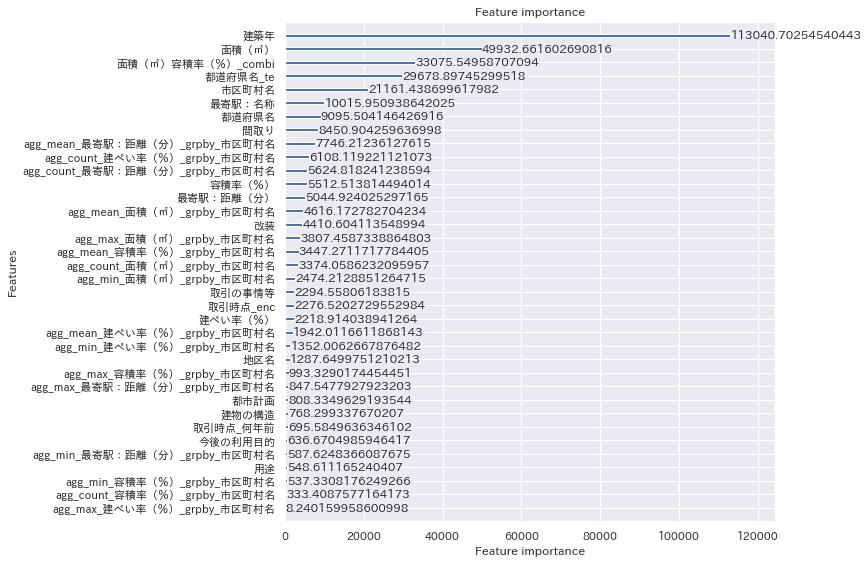

In [ ]:
lgb.plot_importance(optimised_model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [ ]:
# LightGBM推論
y_pred = optimised_model.predict(test_x)

In [ ]:
test_df[TARGET] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [ ]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))